In [1]:
import torch as th
import numpy as np

In [2]:
hidden_activations = th.load("./activations/hidde_activations_2023_30_06_16_49.pt")
output_activations = th.load("./activations/output_activation2023_30_06_16_49.pt")
predicted = th.load("./predicted/predicted_labels2023_30_06_16_49.pt")

hidden_activations = hidden_activations.numpy()
output_activations = output_activations.numpy()
predicted = predicted.numpy()

In [3]:
hidden_layer_neurons = hidden_activations.shape[1]

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)

kmeans.fit_transform(output_activations)
kmeans_labels = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
kmeans_indexes = []  # stores indexes of test point in each cluster
associations = (
    []
)  # associations[i] is a tuple with the label associated with i-th cluster, with the given probability
for i in range(10):
    kmeans_cluster = np.where(kmeans_labels == i)[0]
    kmeans_indexes.append(kmeans_cluster)

    labels, freq = np.unique(predicted[kmeans_cluster[i]], return_counts=True)
    print(
        f"KMEANS CLUSTER {i}. Labels:{labels}. Frequency: {freq} ---> Cluster {i} associated with label {labels[np.argmax(freq)]} with prob. {100*np.max(freq)/np.sum(freq)}%"
    )
    associations.append((labels[np.argmax(freq)], np.max(freq) / np.sum(freq)))

KMEANS CLUSTER 0. Labels:[4]. Frequency: [1] ---> Cluster 0 associated with label 4 with prob. 100.0%
KMEANS CLUSTER 1. Labels:[3]. Frequency: [1] ---> Cluster 1 associated with label 3 with prob. 100.0%
KMEANS CLUSTER 2. Labels:[1]. Frequency: [1] ---> Cluster 2 associated with label 1 with prob. 100.0%
KMEANS CLUSTER 3. Labels:[0]. Frequency: [1] ---> Cluster 3 associated with label 0 with prob. 100.0%
KMEANS CLUSTER 4. Labels:[7]. Frequency: [1] ---> Cluster 4 associated with label 7 with prob. 100.0%
KMEANS CLUSTER 5. Labels:[5]. Frequency: [1] ---> Cluster 5 associated with label 5 with prob. 100.0%
KMEANS CLUSTER 6. Labels:[6]. Frequency: [1] ---> Cluster 6 associated with label 6 with prob. 100.0%
KMEANS CLUSTER 7. Labels:[2]. Frequency: [1] ---> Cluster 7 associated with label 2 with prob. 100.0%
KMEANS CLUSTER 8. Labels:[9]. Frequency: [1] ---> Cluster 8 associated with label 9 with prob. 100.0%
KMEANS CLUSTER 9. Labels:[2]. Frequency: [1] ---> Cluster 9 associated with label 

kmeans_indexes[0] stores the index of the test point in cluster 0


In [6]:
# store the hidden activations for each of the 10 cluster:
hidden_activ_per_clusters = []

for i in range(10):
    # seleziono le hidden activation dei test point corrispondenti
    hidden_activ_per_clusters.append(hidden_activations[kmeans_indexes[i]])

In [7]:
top_activations = [[] for _ in range(10)]
for i in range(10):
    for j in range(hidden_activ_per_clusters[i].shape[0]):
        top_activations[i].append(hidden_activ_per_clusters[i][j].argsort()[-5:][::-1])

In [8]:
neurons_IDs = []  # gli interi qui dentro corrispondono all'ID di un neurone
frequencies = []

for i in range(10):
    values, counts = np.unique(
        np.stack(top_activations[i]).flatten(), return_counts=True
    )
    neurons_IDs.append(values)
    frequencies.append(counts)

In [9]:
best_neurons_per_cluster = []
for i in range(10):
    idxs = list(frequencies[i].argsort()[-5:][::-1])
    best_neurons_per_cluster.append(neurons_IDs[i][idxs])

best_neurons_per_cluster

[array([42, 22, 51,  3, 50]),
 array([47, 74, 22, 64, 53]),
 array([65, 80, 83,  9, 90]),
 array([85, 13, 53,  3, 47]),
 array([51,  2, 47, 30, 90]),
 array([74, 47, 35, 64, 67]),
 array([64,  3, 71, 22, 29]),
 array([64, 22, 47,  3, 53]),
 array([51, 42,  2, 47, 22]),
 array([64, 39,  4,  3, 49])]

## Resulting plot


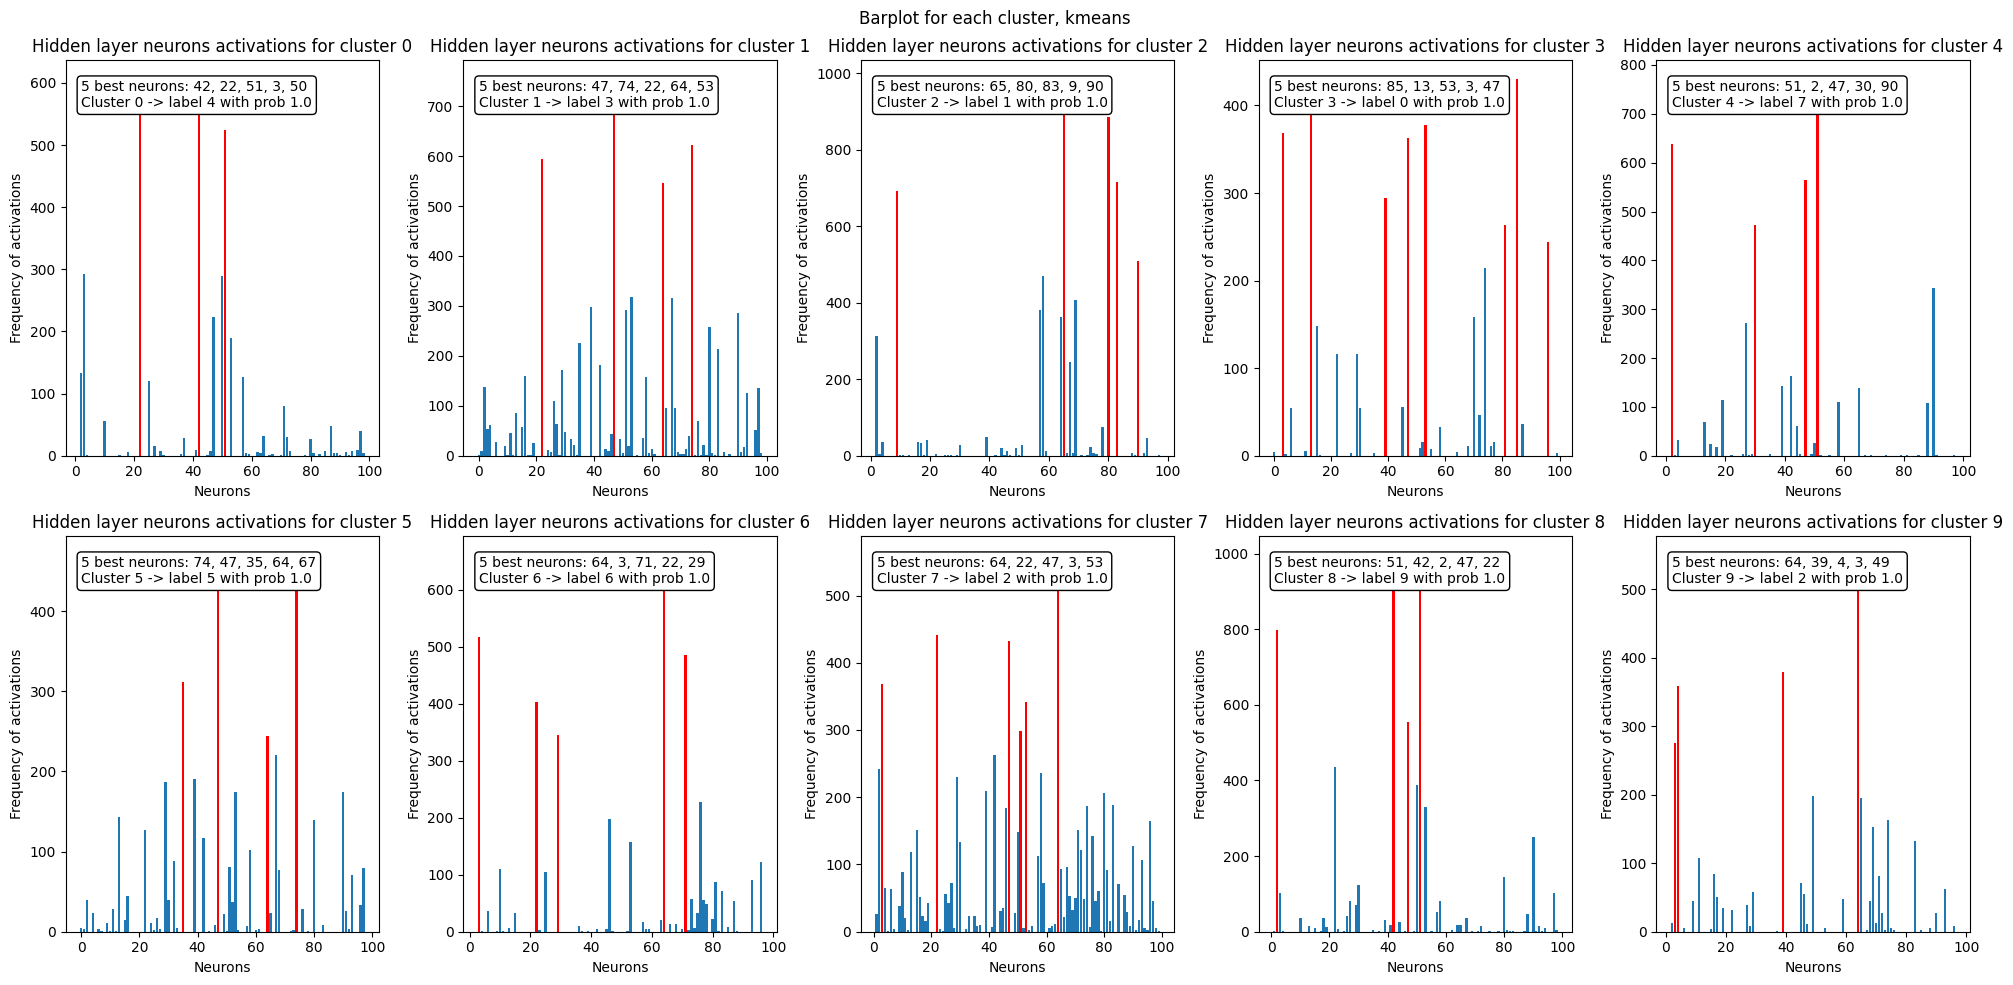

In [10]:
from src.evaluation import barplot_grid, heatmap

barplot_grid(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    suptitle="kmeans",
)

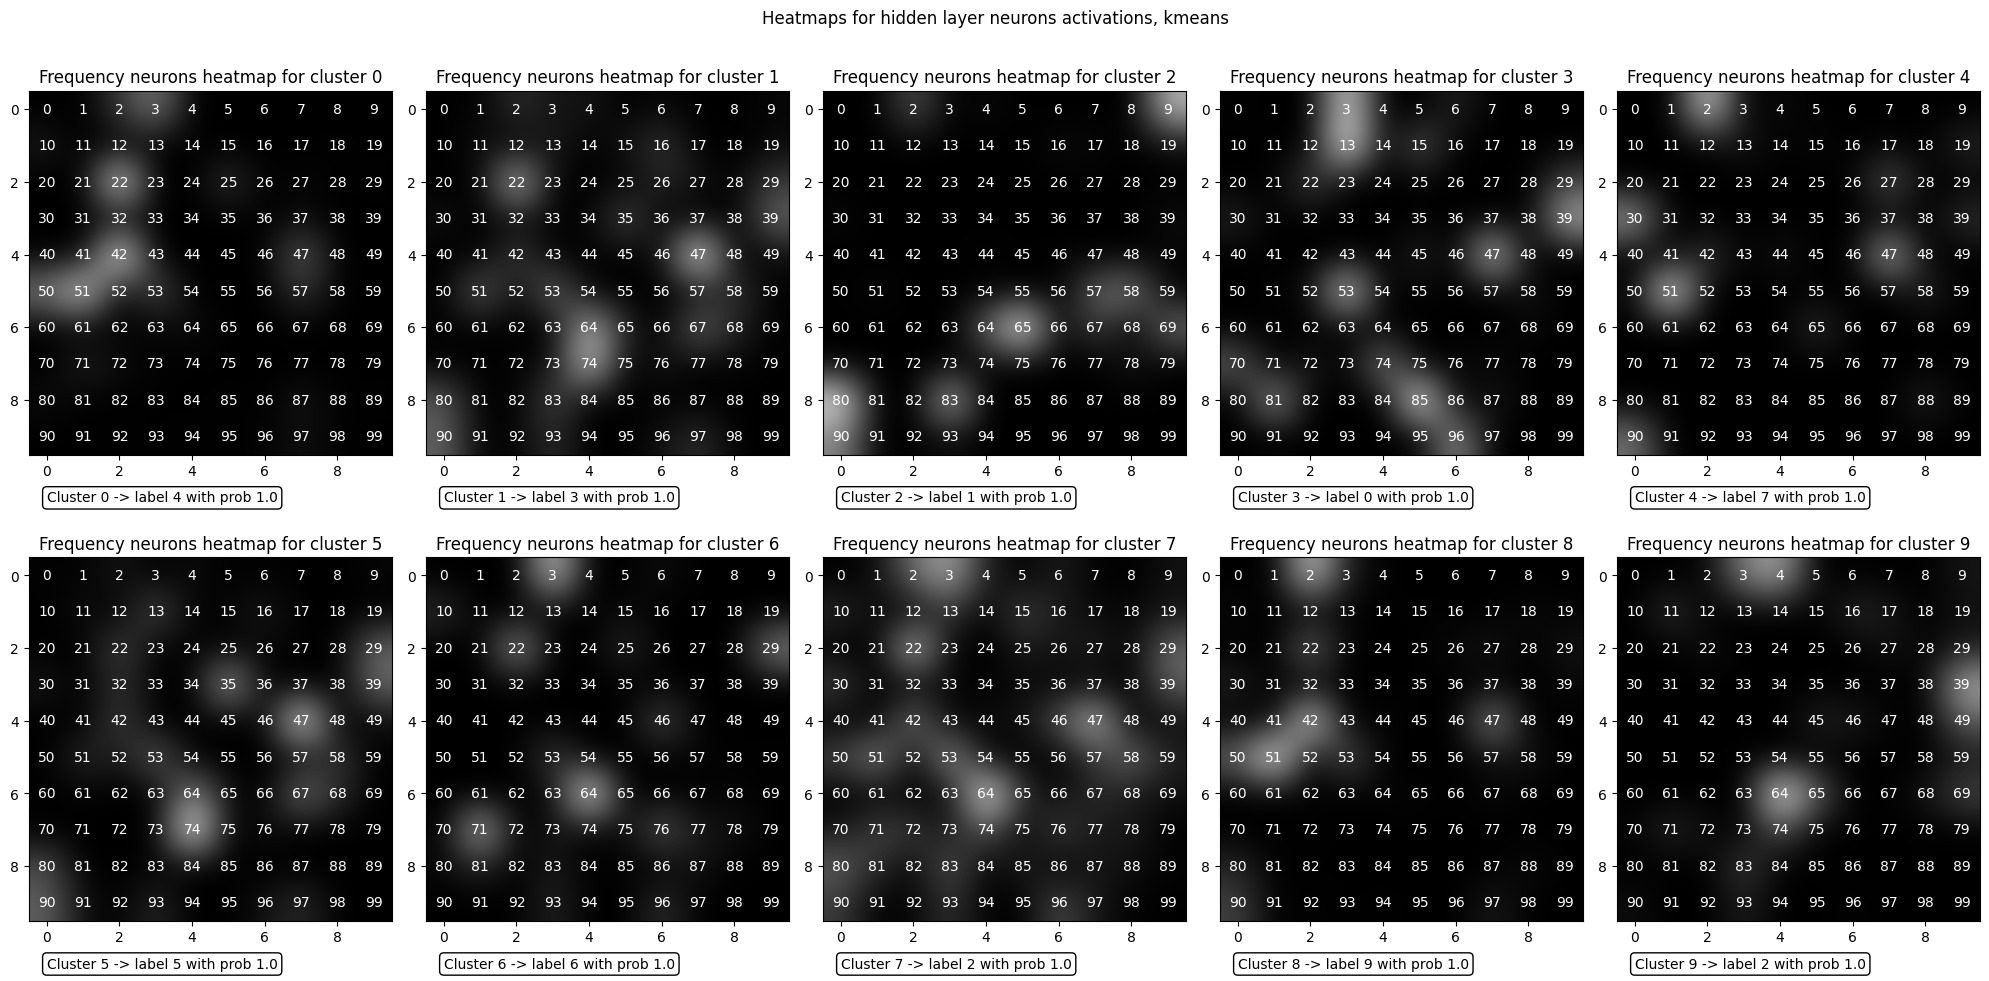

In [11]:
heatmap(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    suptitle="kmeans",
)

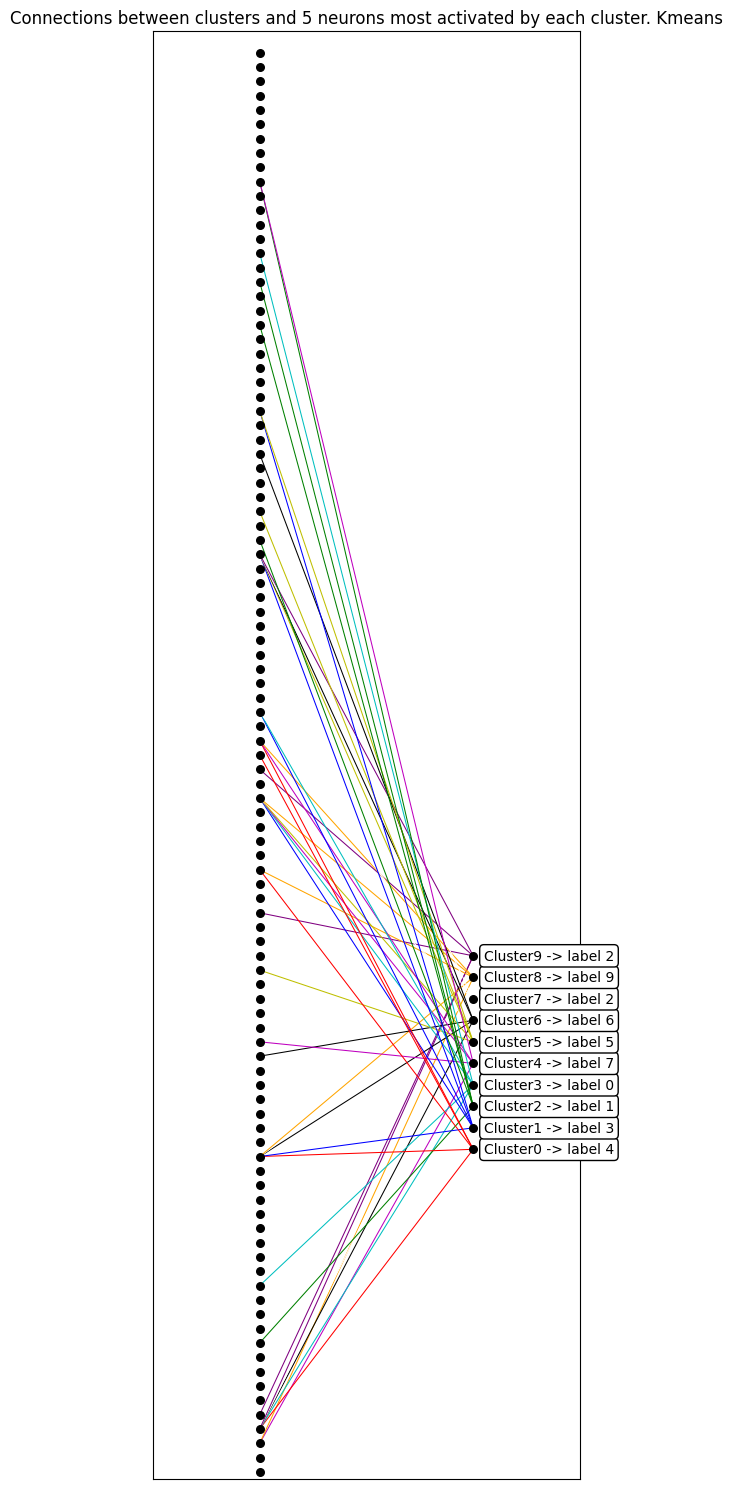

In [12]:
from src.evaluation import connections

connections(
    best_neurons_per_cluster=best_neurons_per_cluster,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    title="Kmeans",
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

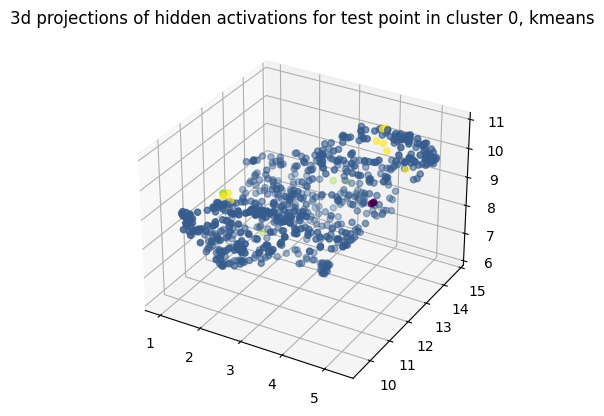

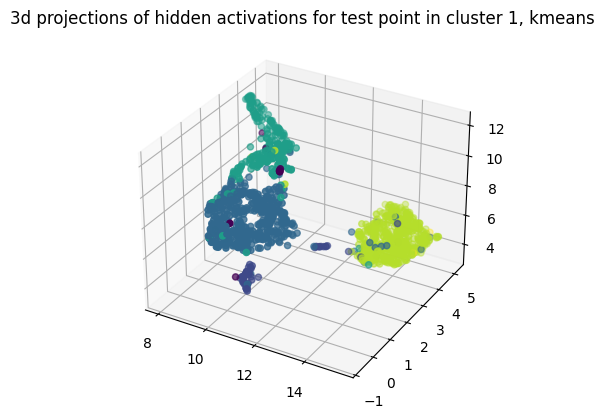

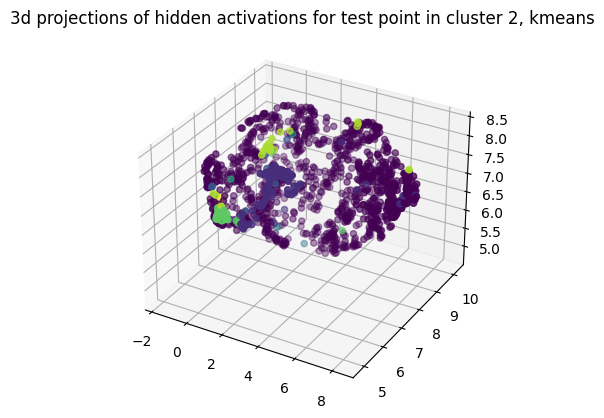

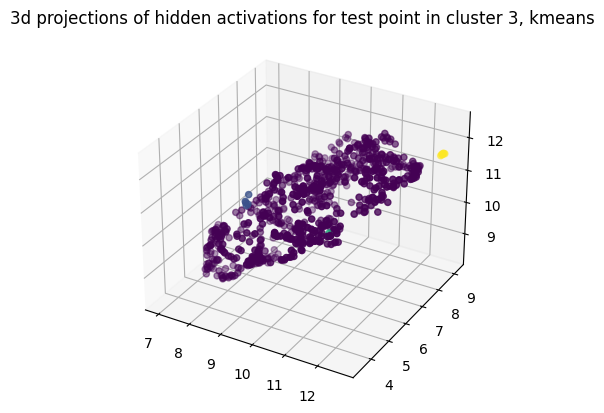

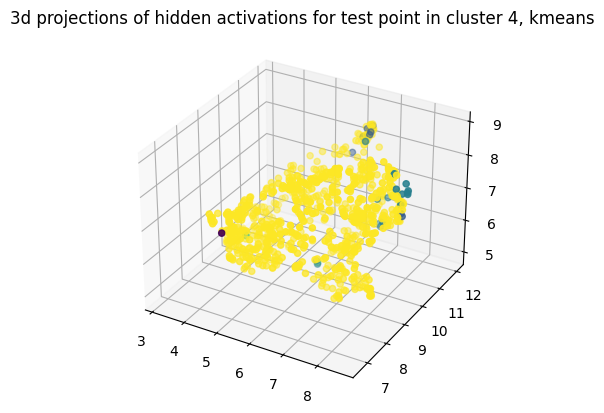

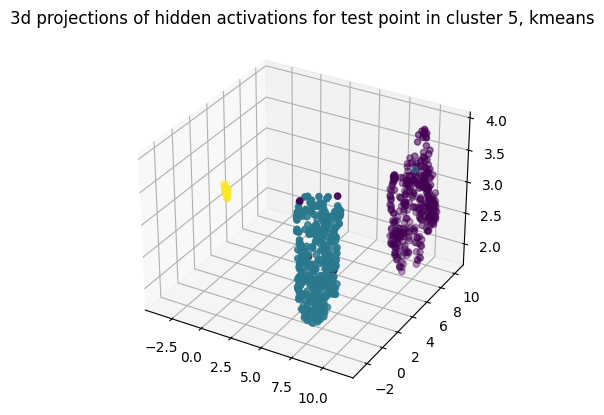

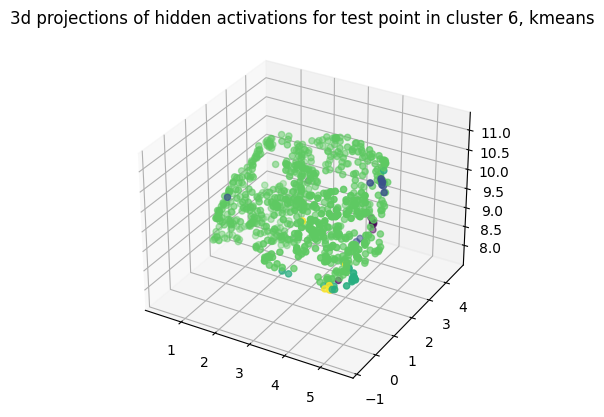

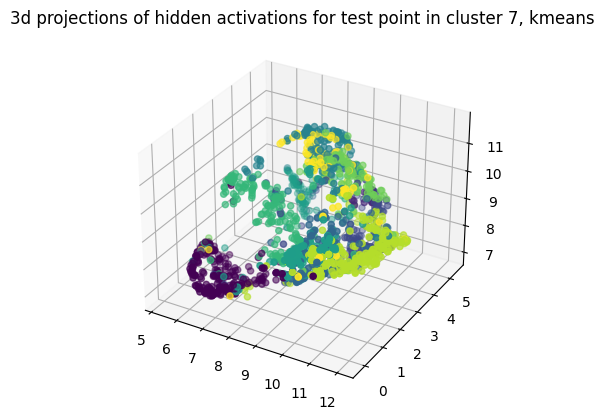

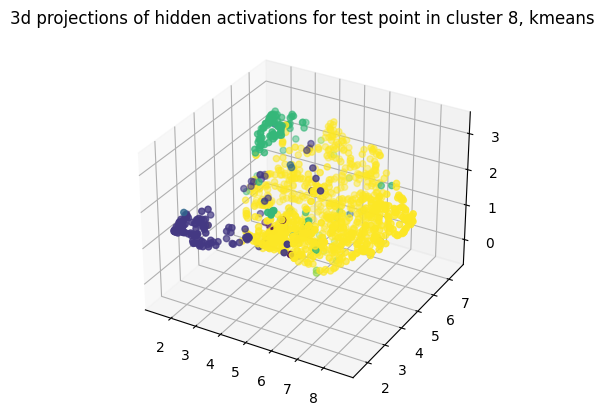

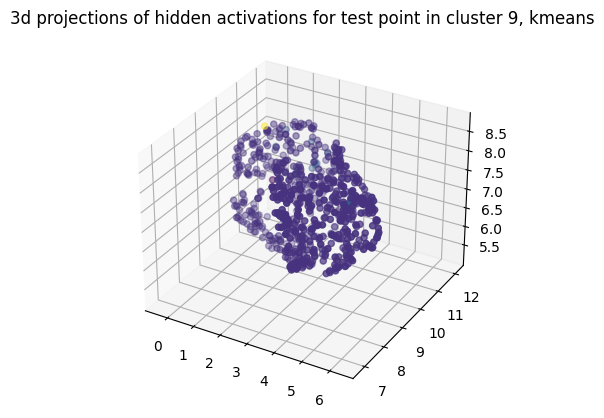

In [13]:
import matplotlib.pyplot as plt
from src.plot_manifold import plot_manifold


for i in range(10):
    plot_manifold(
        data=hidden_activations[kmeans_indexes[i]],
        title=f"3d projections of hidden activations for test point in cluster {i}, kmeans",
        predicted=predicted[kmeans_indexes[i]],
    )

    plt.show()

In [14]:
weights_first_layer = th.load("./weights/weights_first_layer_2023_30_06_16_49.pt")

weights_first_layer = weights_first_layer.numpy()

weights_per_cluster = (
    []
)  # weights_per_cluster[i] stores the weights for the 5 'best' neurons in the i-th cluster. (nb consider the weights che uniscono il primo layer al neurone del secondo layer)
for i in range(10):
    weights_per_cluster.append(weights_first_layer[best_neurons_per_cluster[i]])

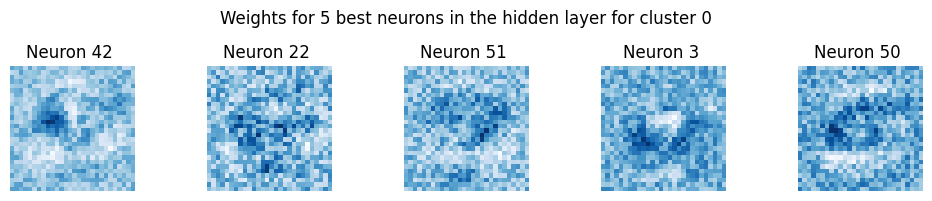

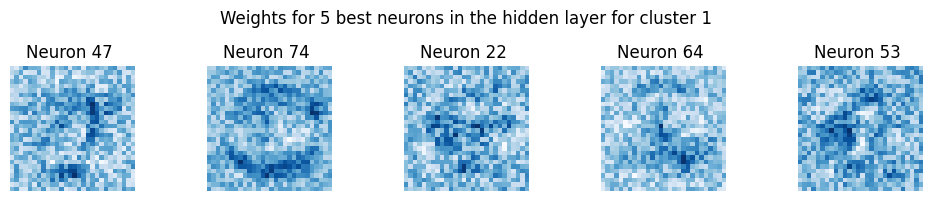

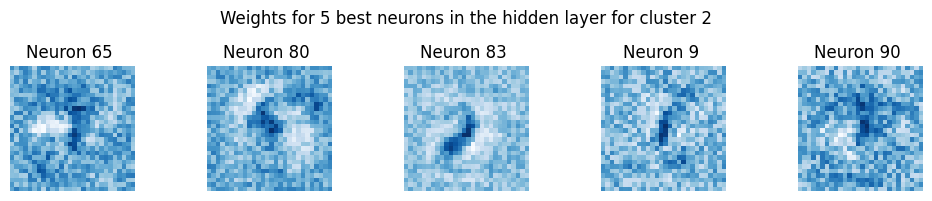

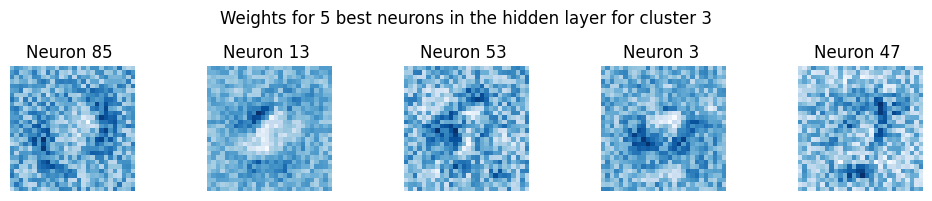

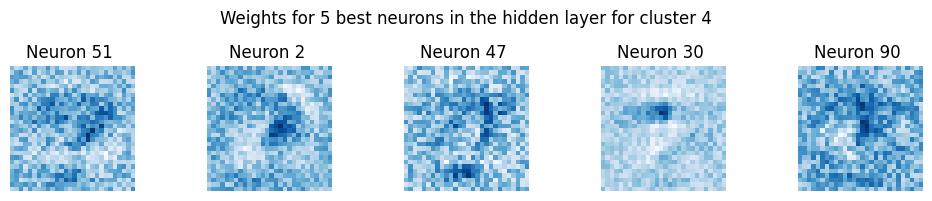

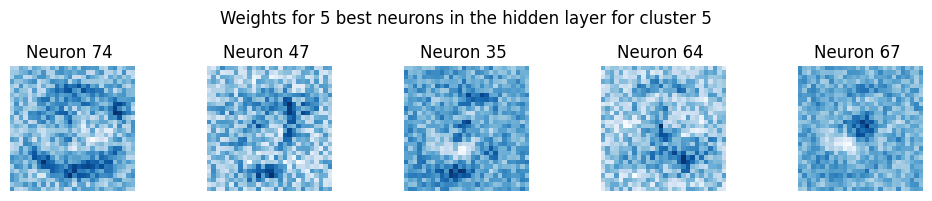

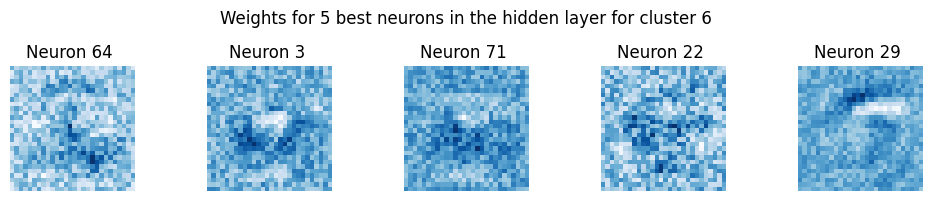

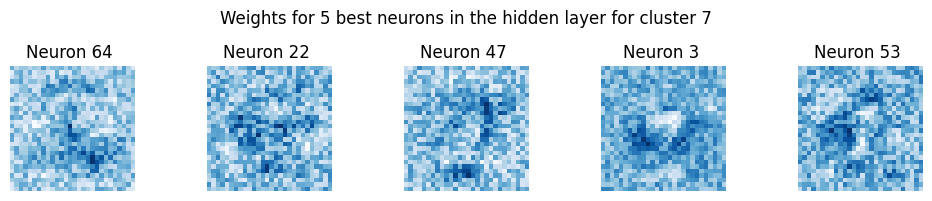

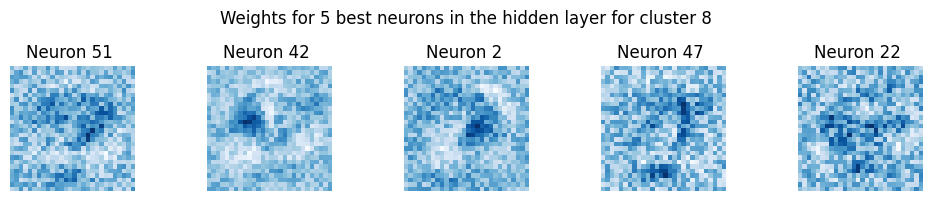

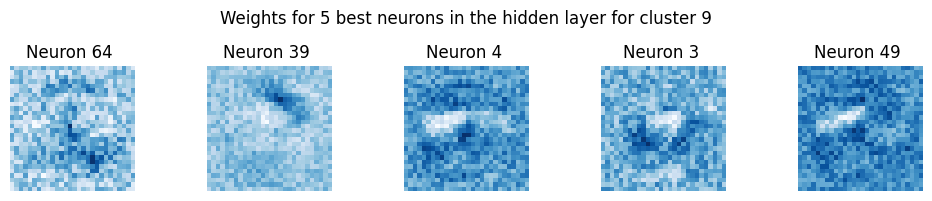

In [15]:
for j in range(10):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))

    # Plot each image in the grid
    for i in range(5):
        axes[i].imshow(weights_per_cluster[j].reshape(5, 28, 28)[i], cmap="Blues")
        axes[i].axis("off")
        axes[i].set_title(f"Neuron {best_neurons_per_cluster[j][i]} ")

    # Display the grid of images
    plt.suptitle(f"Weights for 5 best neurons in the hidden layer for cluster {j}")
    plt.tight_layout()

    plt.show()